# Step 2

### Target:
- Add batch normalization to the model
- Add dropout to the model
- Use Global Average Pooling instead of normal convolutional layer

### Results:
- Parameters: 7,498
- Best Train Accuracy: 98.47%
- Best Test Accuracy: 99.30% (13th epoch)

### Analysis:
- Test accuracy increased from 99.09% to 99.30% in 13th epoch
- The model seems to be saturated on the training dataset
- Need to add more augmentation techniques to improve the model accuracy
- Need to use learning rate scheduler to achieve accuracy goals quicker

## Install Dependencies

In [1]:
!pip install torchsummary --quiet
!pip install tqdm --quiet
!pip install matplotlib --quiet

## Import Libraries

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt

## Import Model

In [3]:
from model_2 import Net

## Print Model Summary

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,296
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
           Conv2d-13           [-1, 10, 22, 22]             120
        MaxPool2d-14           [-1, 10,

## Transformations for Training and Testing Datasets

In [5]:
# Train Dataset transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop((28, 28), (0.85, 1.0)),
    transforms.RandomRotation((-7., 7.), fill=0),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test Dataset transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.1325,), (0.3104,))
    ])

## Training and Testing Datasets

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:10<00:00, 901kB/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.72MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Training and Testing Dataloaders

In [7]:
SEED = 8

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# Dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=128)

# Train & Test Dataloaders
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Data Statistics

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8140)
 - mean: tensor(-0.0692)
 - std: tensor(0.7163)
 - var: tensor(0.5130)
torch.Size([128, 1, 28, 28])
torch.Size([128])


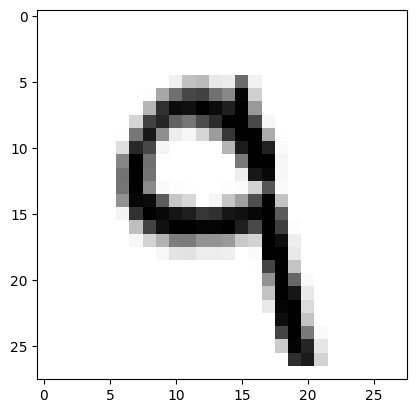

In [8]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## Data Visualization

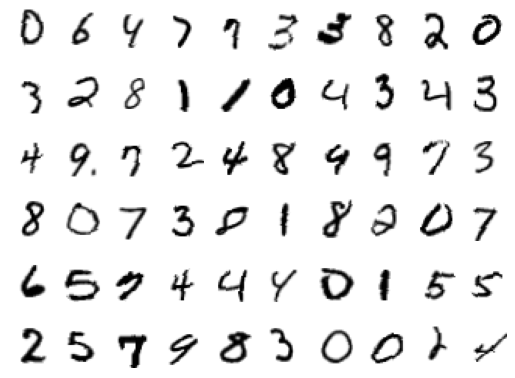

In [9]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Training and Testing Loops

In [10]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []


def train(model, device, train_loader, optimizer, epoch):
    """
    Training Loop
    :param model: Model
    :param device: Device
    :param train_loader: Training Dataloader
    :param optimizer: Optimizer
    :param epoch: Epoch
    """
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # Get Samples
        data, target = data.to(device), target.to(device)

        # Set gradients to zero
        optimizer.zero_grad()

        # Predict
        output = model(data)

        # Calculate loss
        loss = F.nll_loss(output, target)
        train_losses.append(loss)

        # Backpropagation
        loss.backward()

        # Update weights
        optimizer.step()

        # Update pbar-tqdm
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'    Train set: Loss={loss.item():0.4f}, Accuracy: {100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    """
    Testing Loop
    :param model: Model
    :param device: Device
    :param test_loader: Testing Dataloader
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))

    print('    Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

## Model Training and Testing

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}:")
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Epoch 1:


    Train set: Loss=0.1457, Accuracy: 90.43: 100%|██████████| 469/469 [00:52<00:00,  8.98it/s]


    Test set: Average loss: 0.0849, Accuracy: 9794/10000 (97.94%)

Epoch 2:


    Train set: Loss=0.1065, Accuracy: 96.59: 100%|██████████| 469/469 [00:50<00:00,  9.32it/s]


    Test set: Average loss: 0.0587, Accuracy: 9844/10000 (98.44%)

Epoch 3:


    Train set: Loss=0.2215, Accuracy: 97.21: 100%|██████████| 469/469 [00:49<00:00,  9.40it/s]


    Test set: Average loss: 0.0455, Accuracy: 9877/10000 (98.77%)

Epoch 4:


    Train set: Loss=0.1774, Accuracy: 97.50: 100%|██████████| 469/469 [00:51<00:00,  9.12it/s]


    Test set: Average loss: 0.0384, Accuracy: 9896/10000 (98.96%)

Epoch 5:


    Train set: Loss=0.0811, Accuracy: 97.83: 100%|██████████| 469/469 [00:52<00:00,  9.01it/s]


    Test set: Average loss: 0.0348, Accuracy: 9891/10000 (98.91%)

Epoch 6:


    Train set: Loss=0.0671, Accuracy: 97.90: 100%|██████████| 469/469 [00:51<00:00,  9.15it/s]


    Test set: Average loss: 0.0384, Accuracy: 9885/10000 (98.85%)

Epoch 7:


    Train set: Loss=0.0831, Accuracy: 98.02: 100%|██████████| 469/469 [00:52<00:00,  8.99it/s]


    Test set: Average loss: 0.0342, Accuracy: 9890/10000 (98.90%)

Epoch 8:


    Train set: Loss=0.0364, Accuracy: 98.11: 100%|██████████| 469/469 [00:51<00:00,  9.03it/s]


    Test set: Average loss: 0.0311, Accuracy: 9904/10000 (99.04%)

Epoch 9:


    Train set: Loss=0.0920, Accuracy: 98.19: 100%|██████████| 469/469 [00:51<00:00,  9.13it/s]


    Test set: Average loss: 0.0319, Accuracy: 9906/10000 (99.06%)

Epoch 10:


    Train set: Loss=0.0787, Accuracy: 98.23: 100%|██████████| 469/469 [00:50<00:00,  9.25it/s]


    Test set: Average loss: 0.0319, Accuracy: 9898/10000 (98.98%)

Epoch 11:


    Train set: Loss=0.0582, Accuracy: 98.37: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]


    Test set: Average loss: 0.0261, Accuracy: 9921/10000 (99.21%)

Epoch 12:


    Train set: Loss=0.0666, Accuracy: 98.31: 100%|██████████| 469/469 [00:52<00:00,  8.98it/s]


    Test set: Average loss: 0.0257, Accuracy: 9924/10000 (99.24%)

Epoch 13:


    Train set: Loss=0.0281, Accuracy: 98.36: 100%|██████████| 469/469 [00:51<00:00,  9.07it/s]


    Test set: Average loss: 0.0242, Accuracy: 9930/10000 (99.30%)

Epoch 14:


    Train set: Loss=0.0188, Accuracy: 98.36: 100%|██████████| 469/469 [00:50<00:00,  9.20it/s]


    Test set: Average loss: 0.0281, Accuracy: 9911/10000 (99.11%)

Epoch 15:


    Train set: Loss=0.0143, Accuracy: 98.47: 100%|██████████| 469/469 [00:52<00:00,  8.87it/s]


    Test set: Average loss: 0.0228, Accuracy: 9927/10000 (99.27%)



## Plotting the Losses and Accuracies

Text(0.5, 1.0, 'Test Accuracy')

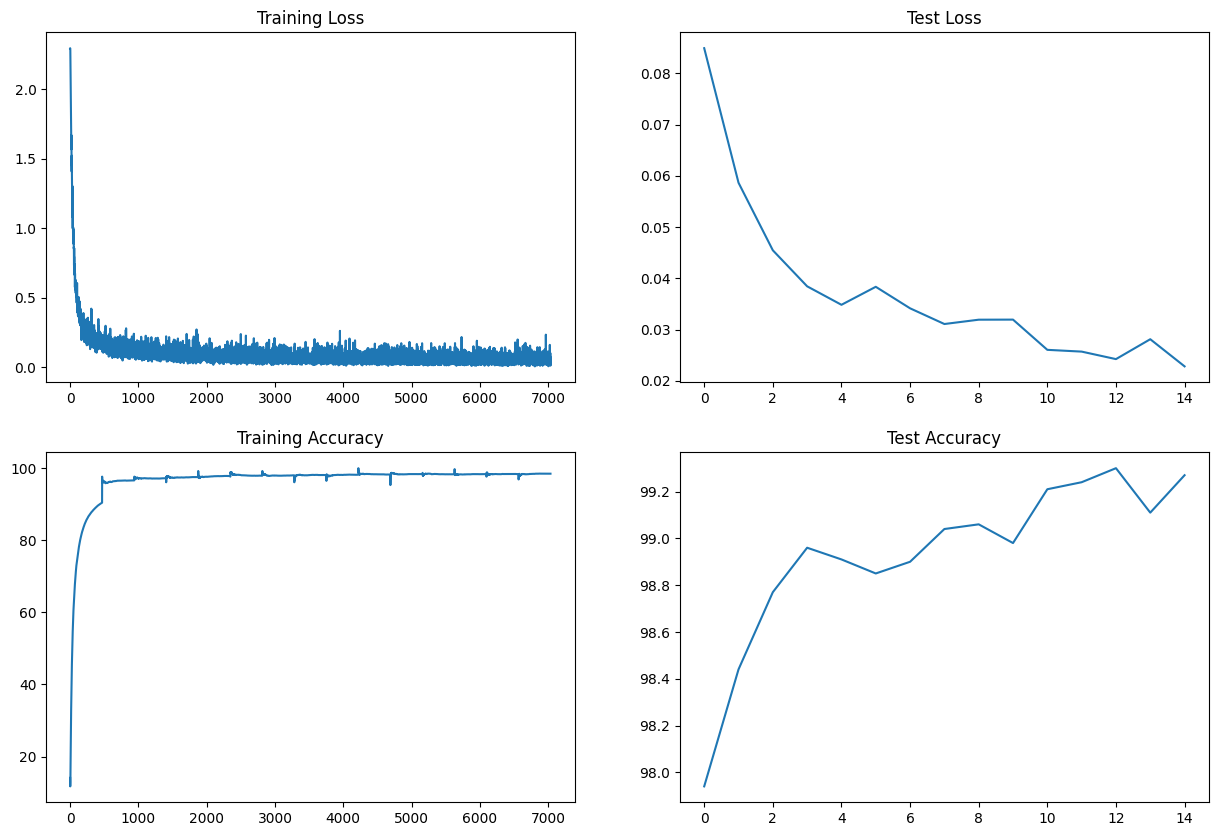

In [12]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")